### Подключаемые модули

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

### Загрузка данных

In [2]:
train_df = pd.read_csv("train.csv")

### Анализ и подготовка данных

In [3]:
train_df.head()

,Unnamed: 0,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
0,6622,ecom,6488536.0,NaN,0,82221,0,0,18.450527,0.461750,2020-04-21 16:04:41.817367072
1,2047,information_source,874840.0,21100.0,0,12872,0,0,10.721619,-0.022317,2024-07-19 23:50:07.268931816
2,1118,information_source,571210.0,94707.0,0,0,7420,0,1.922243,0.046396,2024-07-13 16:35:54.794883135
3,4992,news,89534.0,924.0,0,834,0,0,2.149243,-0.093360,2024-09-10 21:29:14.006315095
4,9970,information_source,1043953.0,289288.0,0,58375,20260,3948,3.764965,0.027303,2024-05-26 11:07:15.950527838


Заметим, что первая колонка 'Unnamed: 0' соответствует колонке ID. Переименуем её сопоставим индексы DataFrame этой колонке

In [4]:
train_df.rename(columns={'Unnamed: 0' : 'ID'}, inplace=True)
train_df.set_index('ID',inplace=True)
train_df.head()

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
ID,,,,,,,,,,
6622,ecom,6488536.0,NaN,0,82221,0,0,18.450527,0.461750,2020-04-21 16:04:41.817367072
2047,information_source,874840.0,21100.0,0,12872,0,0,10.721619,-0.022317,2024-07-19 23:50:07.268931816
1118,information_source,571210.0,94707.0,0,0,7420,0,1.922243,0.046396,2024-07-13 16:35:54.794883135
4992,news,89534.0,924.0,0,834,0,0,2.149243,-0.093360,2024-09-10 21:29:14.006315095
9970,information_source,1043953.0,289288.0,0,58375,20260,3948,3.764965,0.027303,2024-05-26 11:07:15.950527838


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 6622 to 9289
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               8000 non-null   object 
 1   clicks                 7727 non-null   float64
 2   likes                  7624 non-null   float64
 3   buys                   8000 non-null   int64  
 4   4xx_errors             8000 non-null   int64  
 5   5xx_errors             8000 non-null   int64  
 6   complaints_count       7527 non-null   object 
 7   average_dwelltime      8000 non-null   float64
 8   source_attractiveness  8000 non-null   float64
 9   date_of_registration   8000 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 687.5+ KB


Некоторые колонки имеют не тот тип, а также сожержать NaN значения.

clicks, likes, complaints_count должны быть int.
Также хотелось бы получше разобраться с date_of_registration

In [6]:
cleared_df = train_df.copy(deep=True)

# Работа с датой
cleared_df['complaints_count'] = pd.to_numeric(cleared_df['complaints_count'], errors='coerce')
cleared_df['date_of_registration'] = pd.to_datetime(cleared_df['date_of_registration'])
cleared_df['age'] = (pd.Timestamp('2024-10-15') - cleared_df['date_of_registration']) / pd.Timedelta(days=365)
cleared_df = cleared_df.drop(['date_of_registration'], axis=1)

# Заполняем пропуски медианным значением
cleared_df.fillna(cleared_df.groupby(['category']).transform('median'), inplace=True)

# Приводим к нужным типам
cleared_df['clicks'] = cleared_df['clicks'].astype('int64')
cleared_df['likes'] = cleared_df['likes'].astype('int64')
cleared_df['buys'] = cleared_df['buys'].astype('int64')
cleared_df['complaints_count'] = cleared_df['complaints_count'].astype('int64')


In [7]:
def draw_corr_matrix(category, data, with_category = True):
    if with_category:
        corr_matrix = data[data['category'] == category].drop(['category'], axis=1).corr()
    else: 
        corr_matrix = data.corr()
    fig, ax = plt.subplots()
    ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.gcf().set_size_inches(15, 15)
    plt.title('Correlation matrix for category: ' + category)
    plt.show()

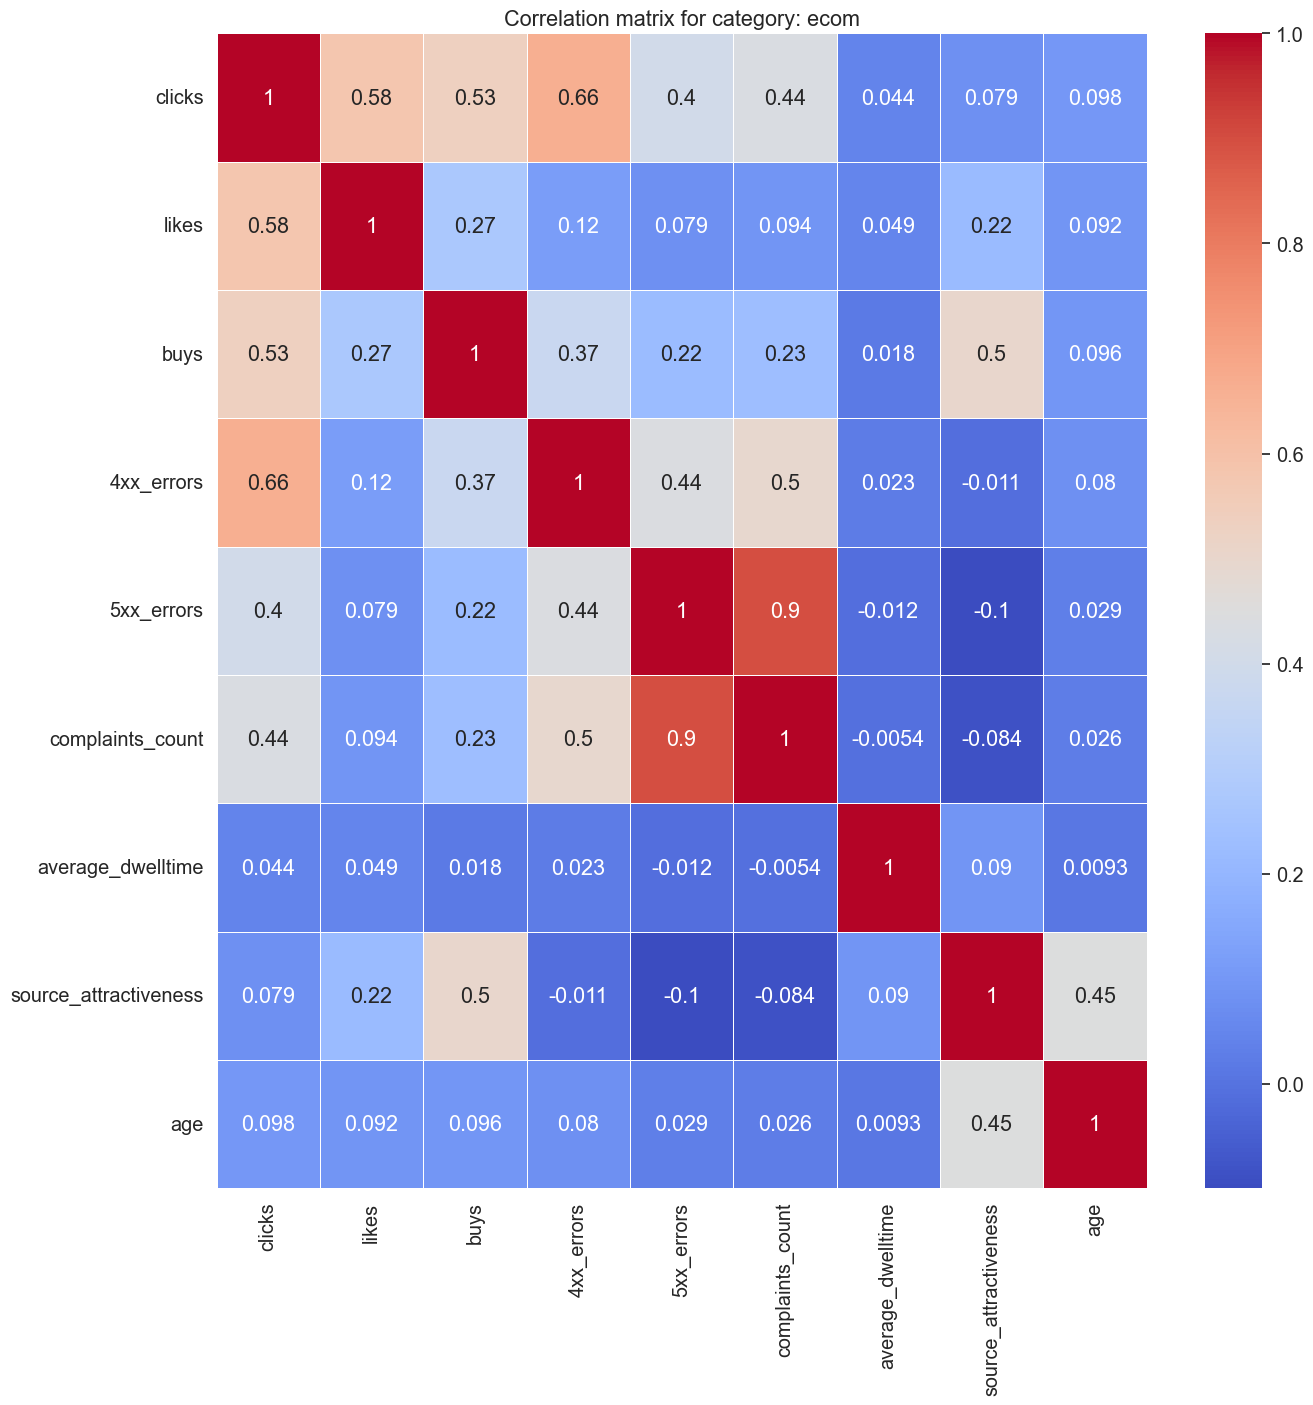

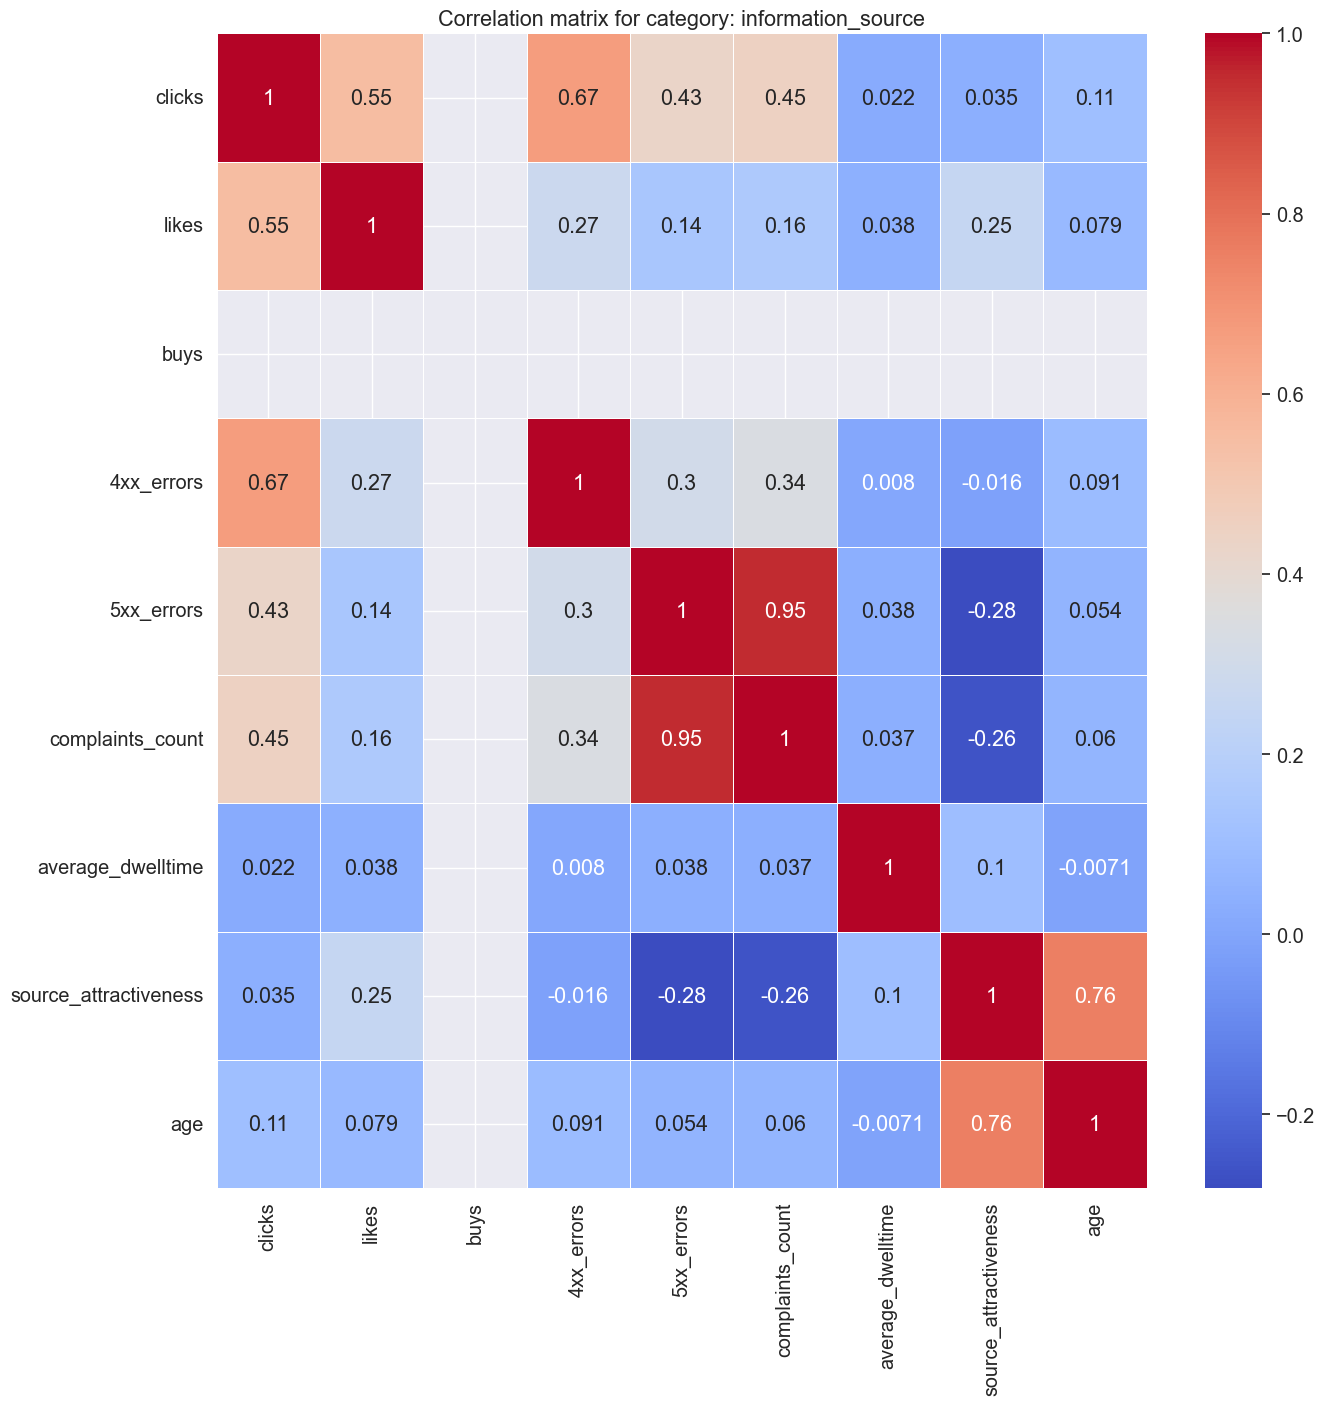

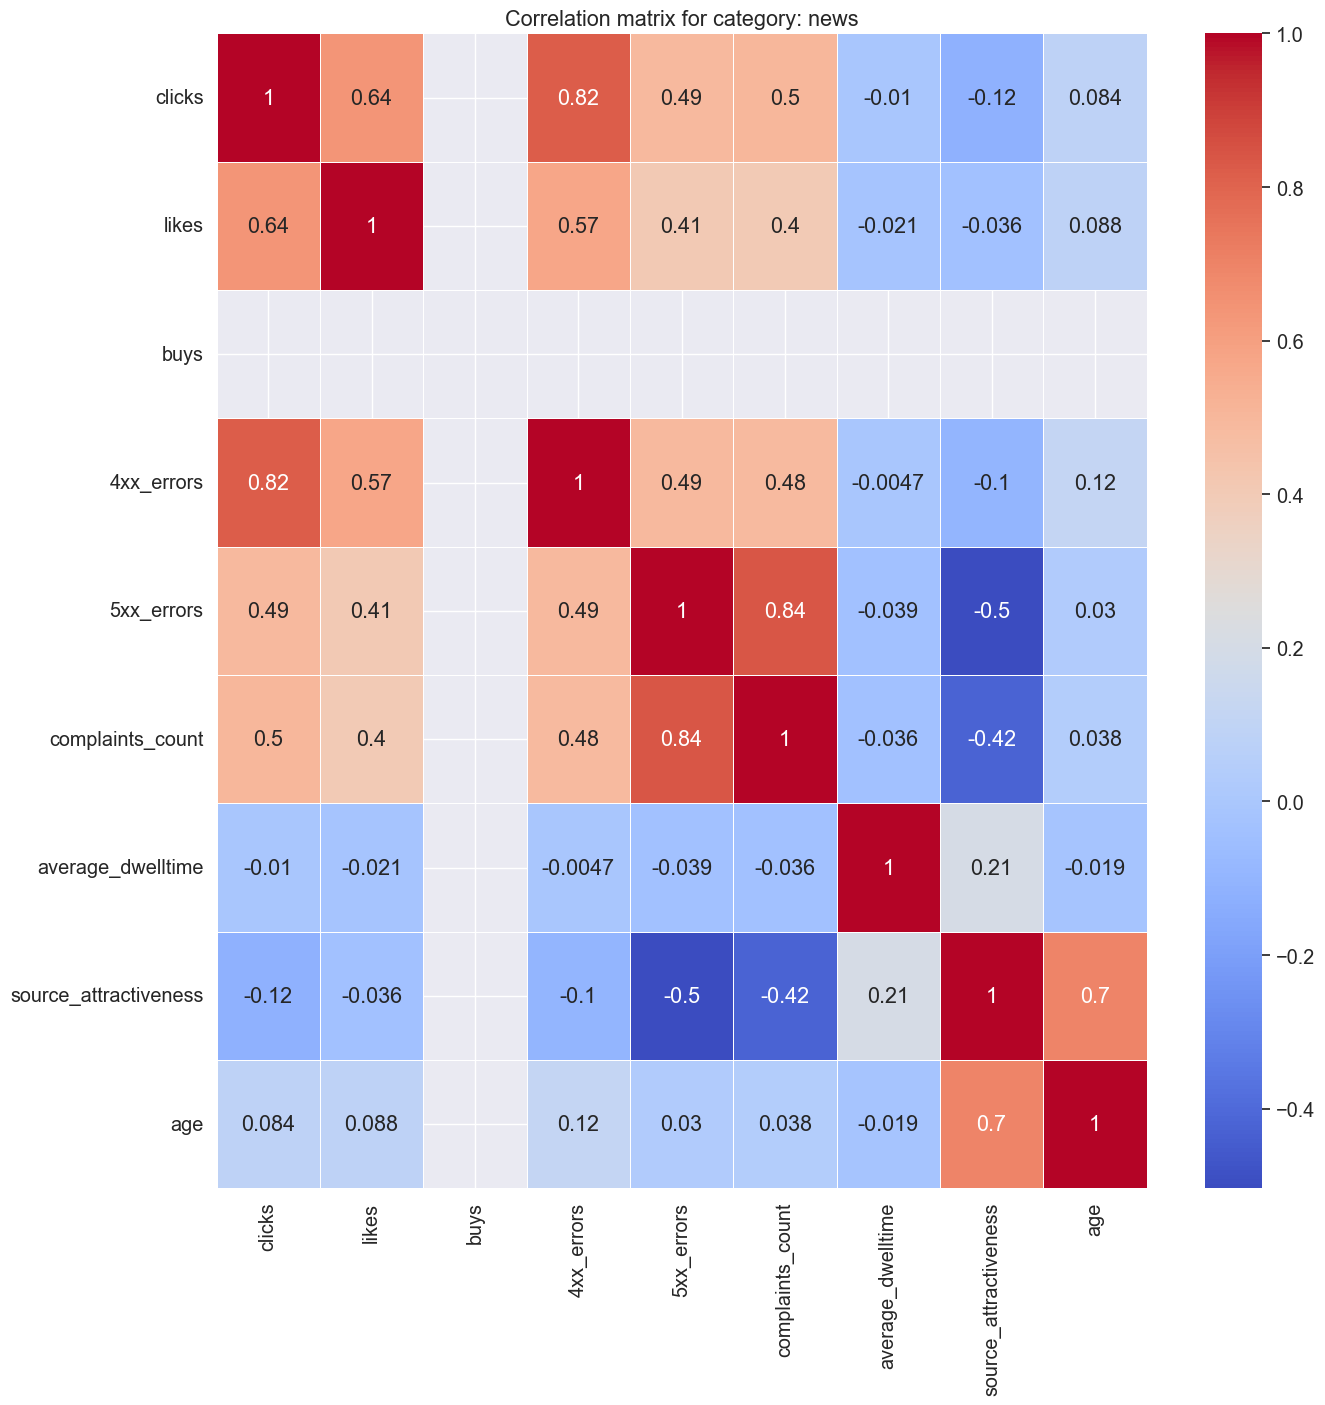

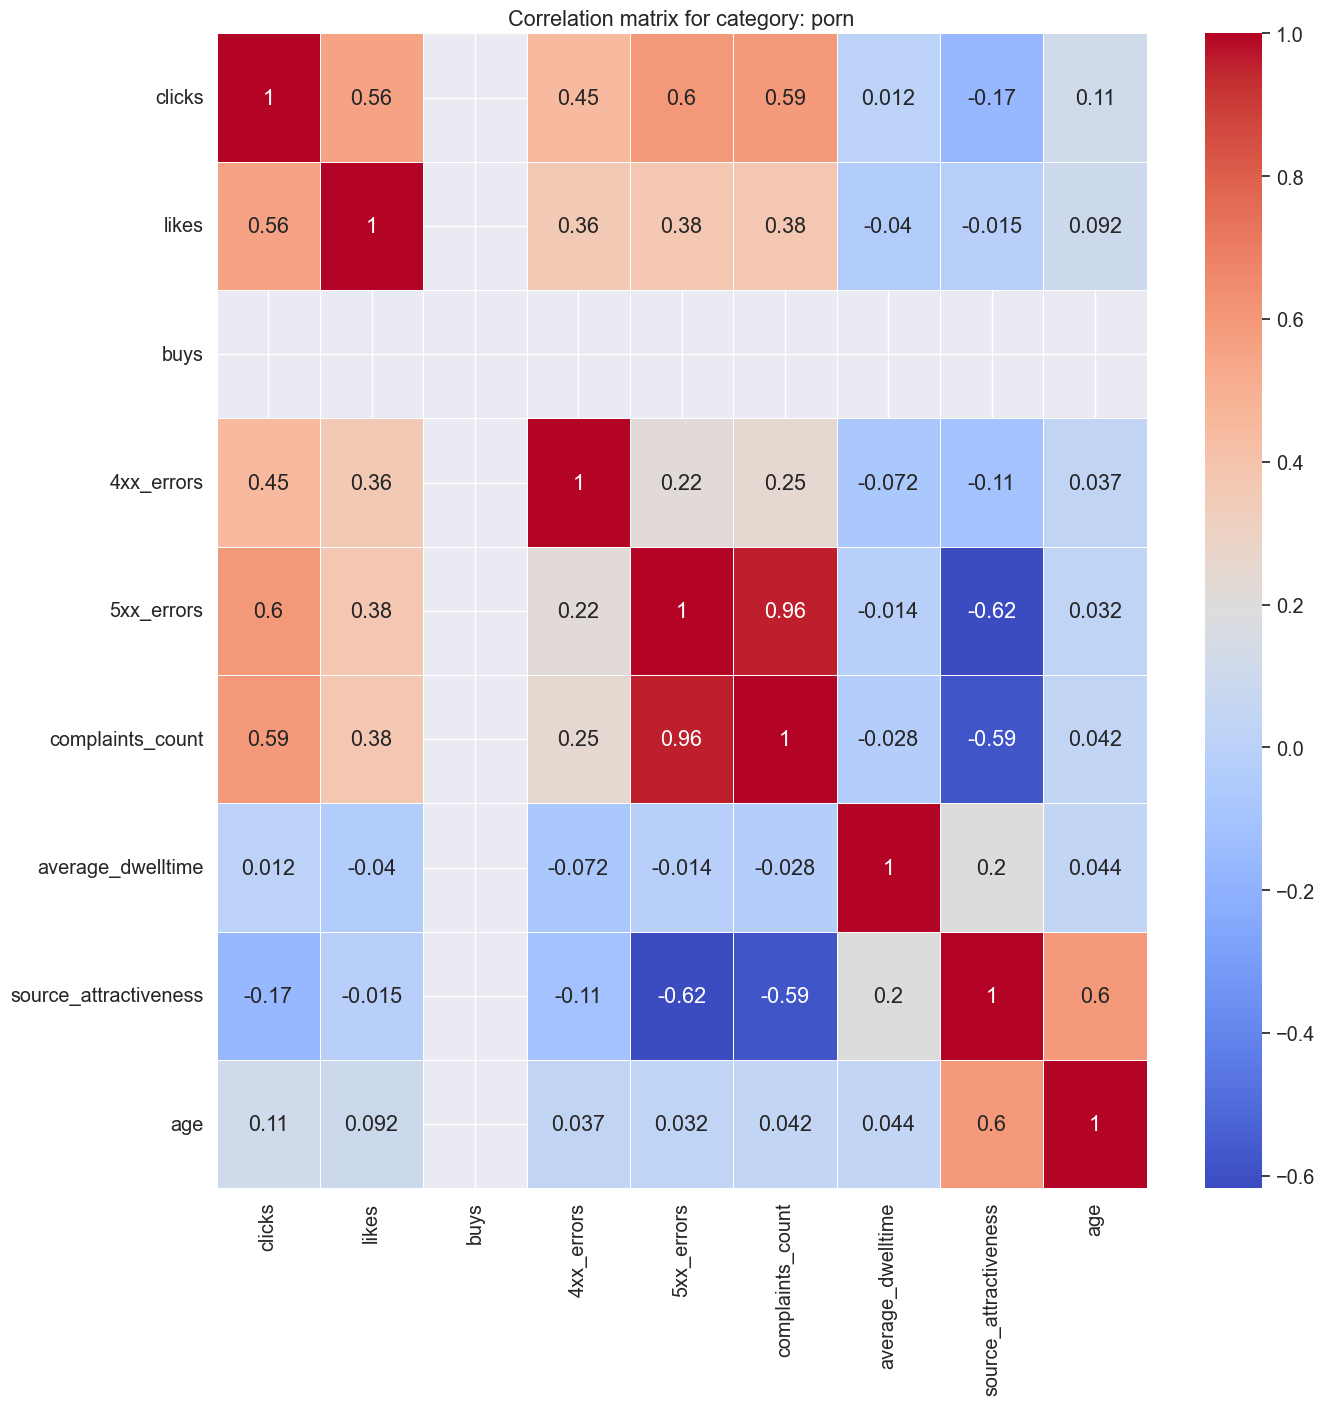

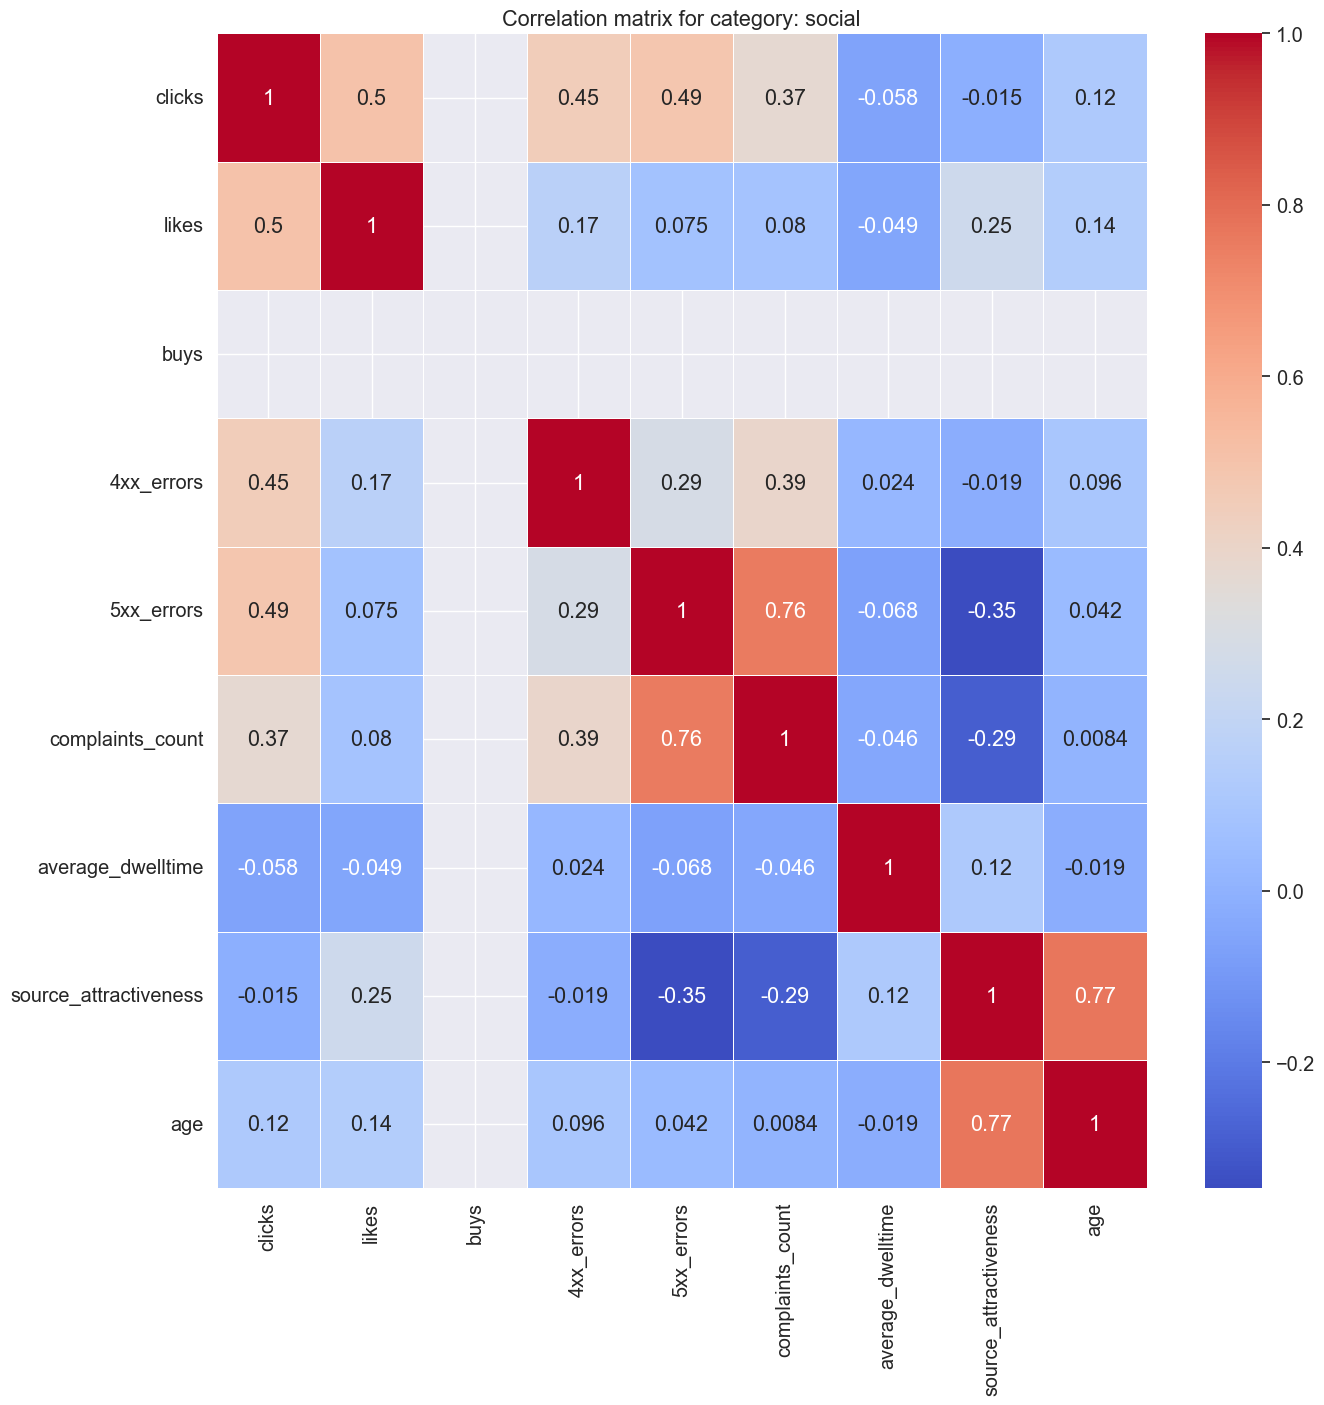

In [8]:
draw_corr_matrix('ecom', cleared_df)
draw_corr_matrix('information_source', cleared_df)
draw_corr_matrix('news', cleared_df)
draw_corr_matrix('porn', cleared_df)
draw_corr_matrix('social', cleared_df)

In [9]:
train_df.describe()

,clicks,likes,buys,4xx_errors,5xx_errors,average_dwelltime,source_attractiveness
count,7.727000e+03,7.624000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8000.000000,8000.000000
mean,2.749785e+06,5.985027e+05,5.810509e+05,8.204958e+04,2.769224e+04,6.979549,0.191997
std,4.699120e+06,1.978345e+06,2.262221e+06,1.555219e+05,7.946935e+04,10.004924,0.227873
min,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-0.681718
25%,3.599210e+05,0.000000e+00,0.000000e+00,2.943000e+03,0.000000e+00,1.503928,0.038220
50%,1.097221e+06,3.399550e+04,0.000000e+00,2.671750e+04,0.000000e+00,4.022802,0.154256
75%,2.915358e+06,2.860638e+05,0.000000e+00,9.500225e+04,2.016375e+04,8.899400,0.282510
max,6.203206e+07,5.582181e+07,4.277391e+07,2.904996e+06,1.865588e+06,211.218066,1.355736


Заметили, что average_dwelltime в данных - отрицательный. Этого быть не может.

In [10]:
cleared_df = cleared_df[cleared_df['average_dwelltime'] >= 0]
cleared_df.describe()

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,age
count,7.593000e+03,7.593000e+03,7.593000e+03,7.593000e+03,7.593000e+03,7593.000000,7593.000000,7593.000000,7593.000000
mean,2.726626e+06,5.828946e+05,5.812593e+05,8.162372e+04,2.729469e+04,5795.067431,7.407269,0.192099,2.056183
std,4.643109e+06,1.952449e+06,2.266554e+06,1.545150e+05,7.829674e+04,15105.482226,10.092981,0.227387,2.037700
min,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000997,-0.681718,0.041631
25%,3.761160e+05,0.000000e+00,0.000000e+00,2.945000e+03,0.000000e+00,288.000000,1.837982,0.038656,0.627969
50%,1.083799e+06,3.273100e+04,0.000000e+00,2.690800e+04,0.000000e+00,1343.000000,4.384810,0.154754,1.421460
75%,2.952505e+06,2.778360e+05,0.000000e+00,9.496800e+04,2.020300e+04,4183.000000,9.276874,0.282519,2.796460
max,6.203206e+07,5.582181e+07,4.277391e+07,2.904996e+06,1.865588e+06,402119.000000,211.218066,1.355736,17.767952


Добавим дополнительные фичи, зависящие от кликов.

In [11]:
cleared_df['likes_per_click'] = cleared_df['likes'] / cleared_df['clicks']
cleared_df['buys_per_click'] = cleared_df['buys'] / cleared_df['clicks']
cleared_df['4xx_errors_per_click'] = cleared_df['4xx_errors'] / cleared_df['clicks']
cleared_df['5xx_errors_per_click'] = cleared_df['5xx_errors'] / cleared_df['clicks']
cleared_df['complaints_count_per_click'] = cleared_df['complaints_count'] / cleared_df['clicks']

# # Уберем колонки с лайками, покупками, ошибками и т.д

#cleared_df = cleared_df.drop(['likes', 'buys', '4xx_errors', '4xx_errors', 'complaints_count'], axis=1)


In [12]:
cleared_df.groupby(by='category').agg(['min', 'max'])

clicks           likes           buys           4xx_errors  \
                      min       max   min       max  min       max        min   
category                                                                        
ecom                  115  62032065     0  55821812    0  42773913          0   
information_source    139   9895544     0   4672787    0         0          0   
news                  151   7347796     0    714773    0         0          0   
porn                  324   1704697     0    290650    0         0          0   
social                 51   6519028     0   2398536    0         0          0   

                            5xx_errors           ... likes_per_click  \
                        max        min      max  ...             min   
category                                         ...                   
ecom                2904996          0  1865588  ...             0.0   
information_source  1187824          0   937276  ...             0.0   
news                 964223          0  1105725  ...             0.0   
porn                 313992          0   388060  ...             0.0   
social               140777          0   221187  ...             0.0   

                               buys_per_click           4xx_errors_per_click  \
                           max            min       max                  min   
category                                                                       
ecom                  8.335663            0.0  5.549719                  0.0   
information_source   20.068056            0.0  0.000000                  0.0   
news                111.430464            0.0  0.000000                  0.0   
porn                  5.074654            0.0  0.000000                  0.0   
social                0.648961            0.0  0.000000                  0.0   

                             5xx_errors_per_click            \
                         max                  min       max   
category                                                      
ecom                0.370868                  0.0  0.242353   
information_source  0.361673                  0.0  0.426223   
news                1.227074                  0.0  1.505641   
porn                0.728417                  0.0  0.492241   
social              0.151031                  0.0  0.070540   

                   complaints_count_per_click             
                                          min        max  
category                                                  
ecom                                      0.0  15.565217  
information_source                        0.0   9.582734  
news                                      0.0   1.692223  
porn                                      0.0   1.317901  
social                                    0.0   0.766204  

[5 rows x 28 columns]

Заметили, что покупки есть только у категории ecom. Значит с этой категорией надо будет работать по особенному. Также уберу эту колонку у остальных категорий.

In [13]:
# Выделяем данные для каждой категории и удаляем колонку buys у колонок != ecom
ecom_data = cleared_df[cleared_df['category'] == 'ecom'].drop(['category'], axis=1)
information_source_data = cleared_df[cleared_df['category'] == 'information_source'].drop(['category', 'buys', 'buys_per_click'], axis=1)
news_data = cleared_df[cleared_df['category'] == 'news'].drop(['category', 'buys', 'buys_per_click'], axis=1)
porn_data = cleared_df[cleared_df['category'] == 'porn'].drop(['category', 'buys', 'buys_per_click'], axis=1)
social_data = cleared_df[cleared_df['category'] == 'social'].drop(['category', 'buys', 'buys_per_click'], axis=1)

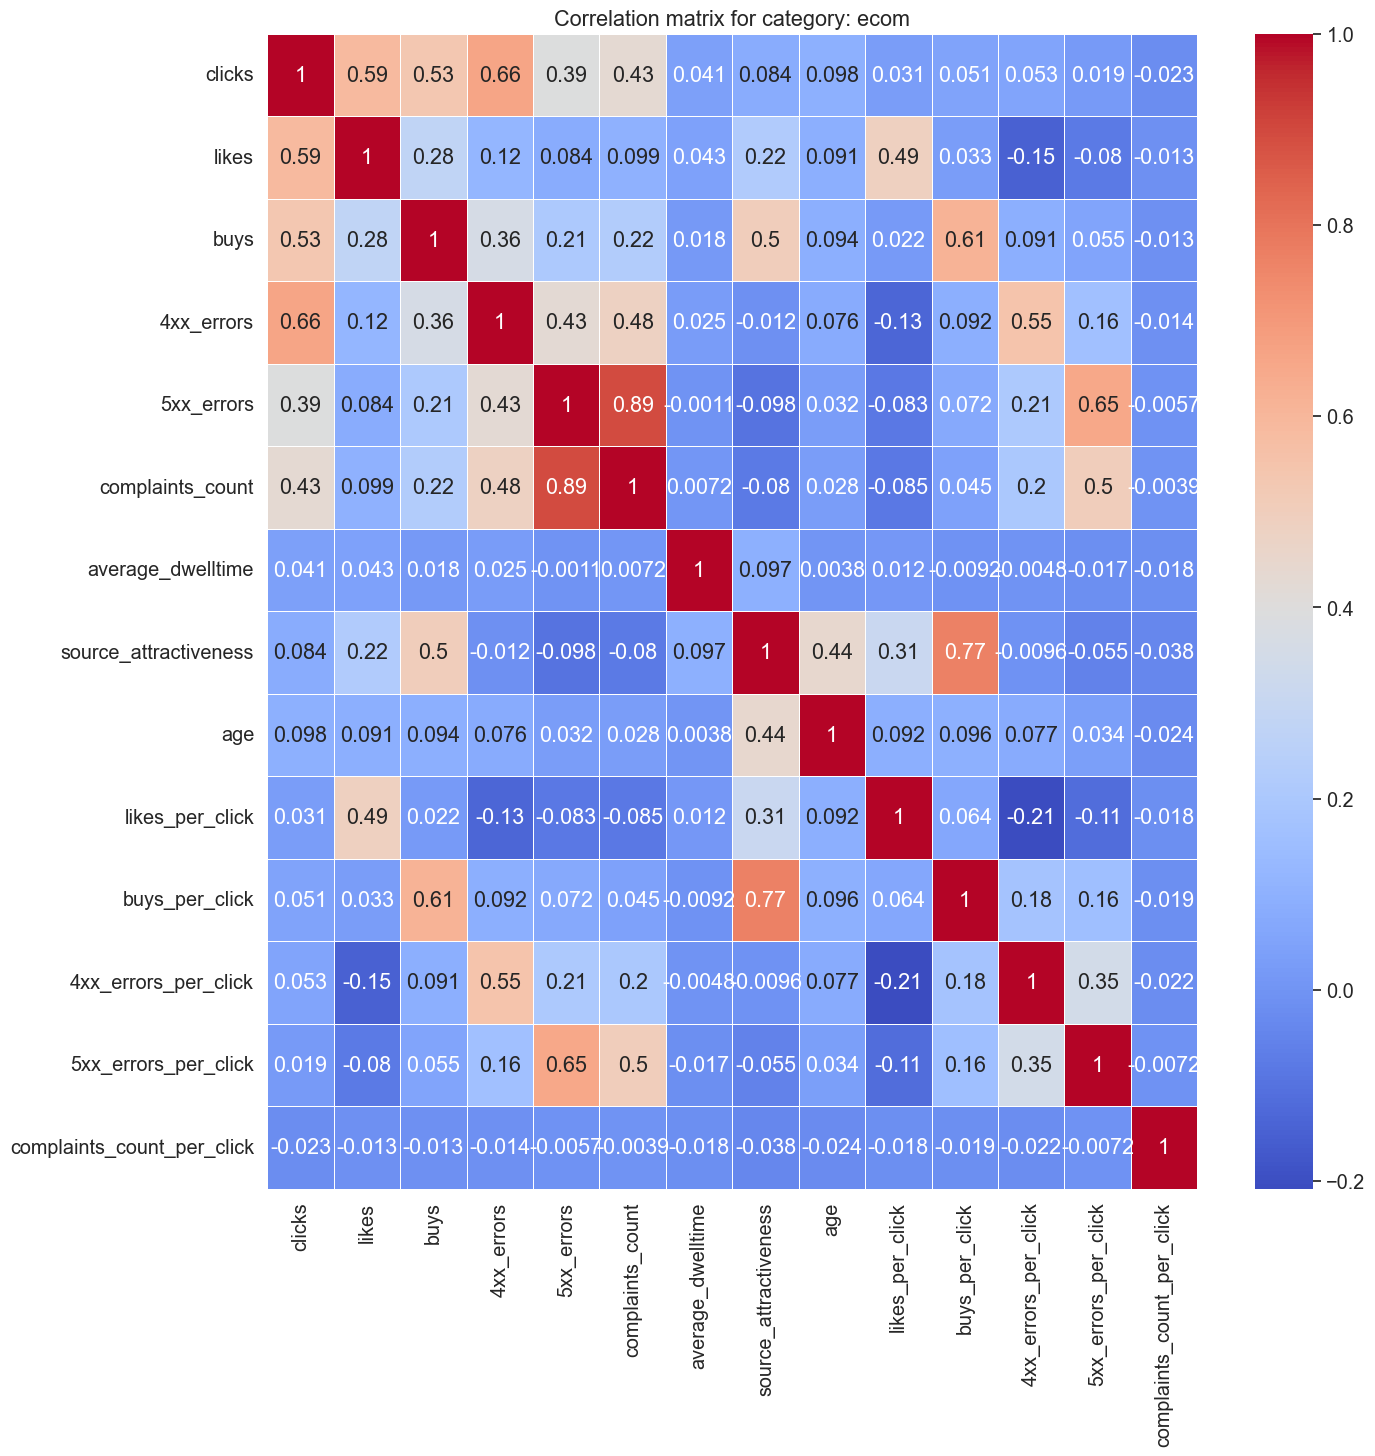

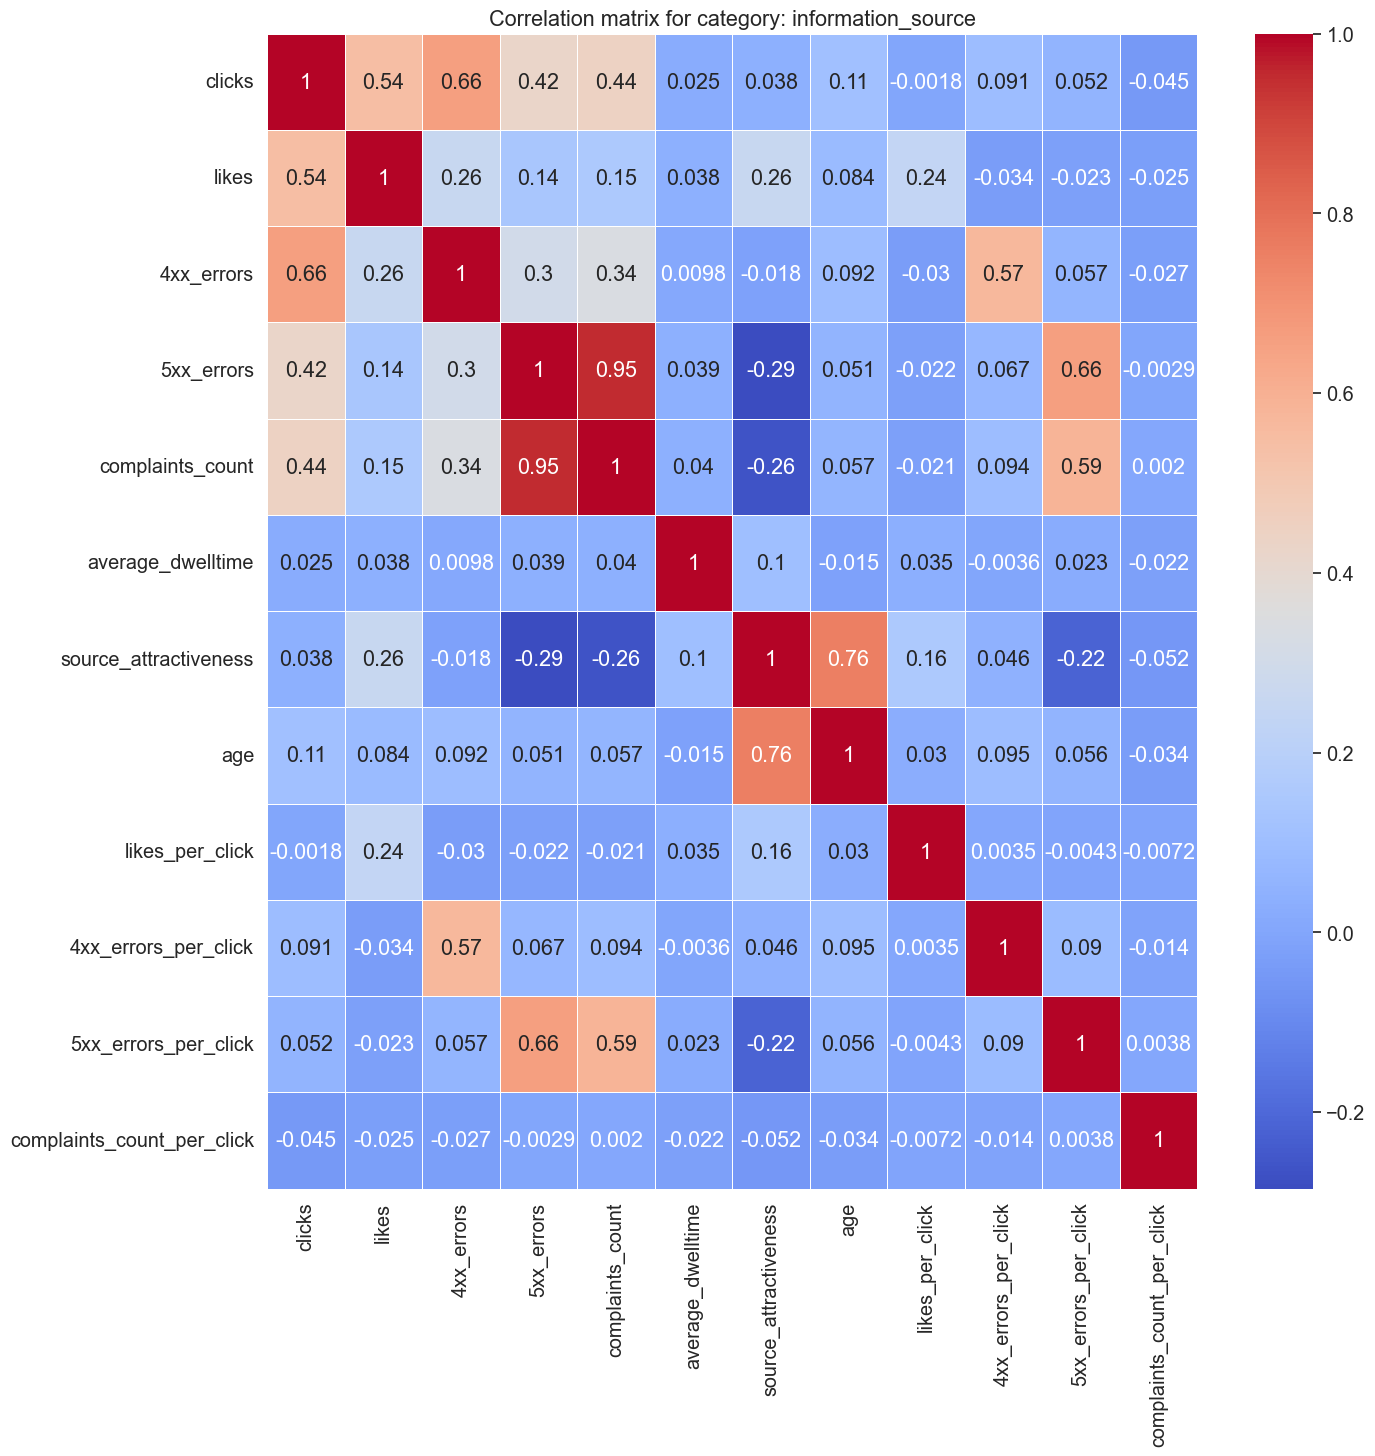

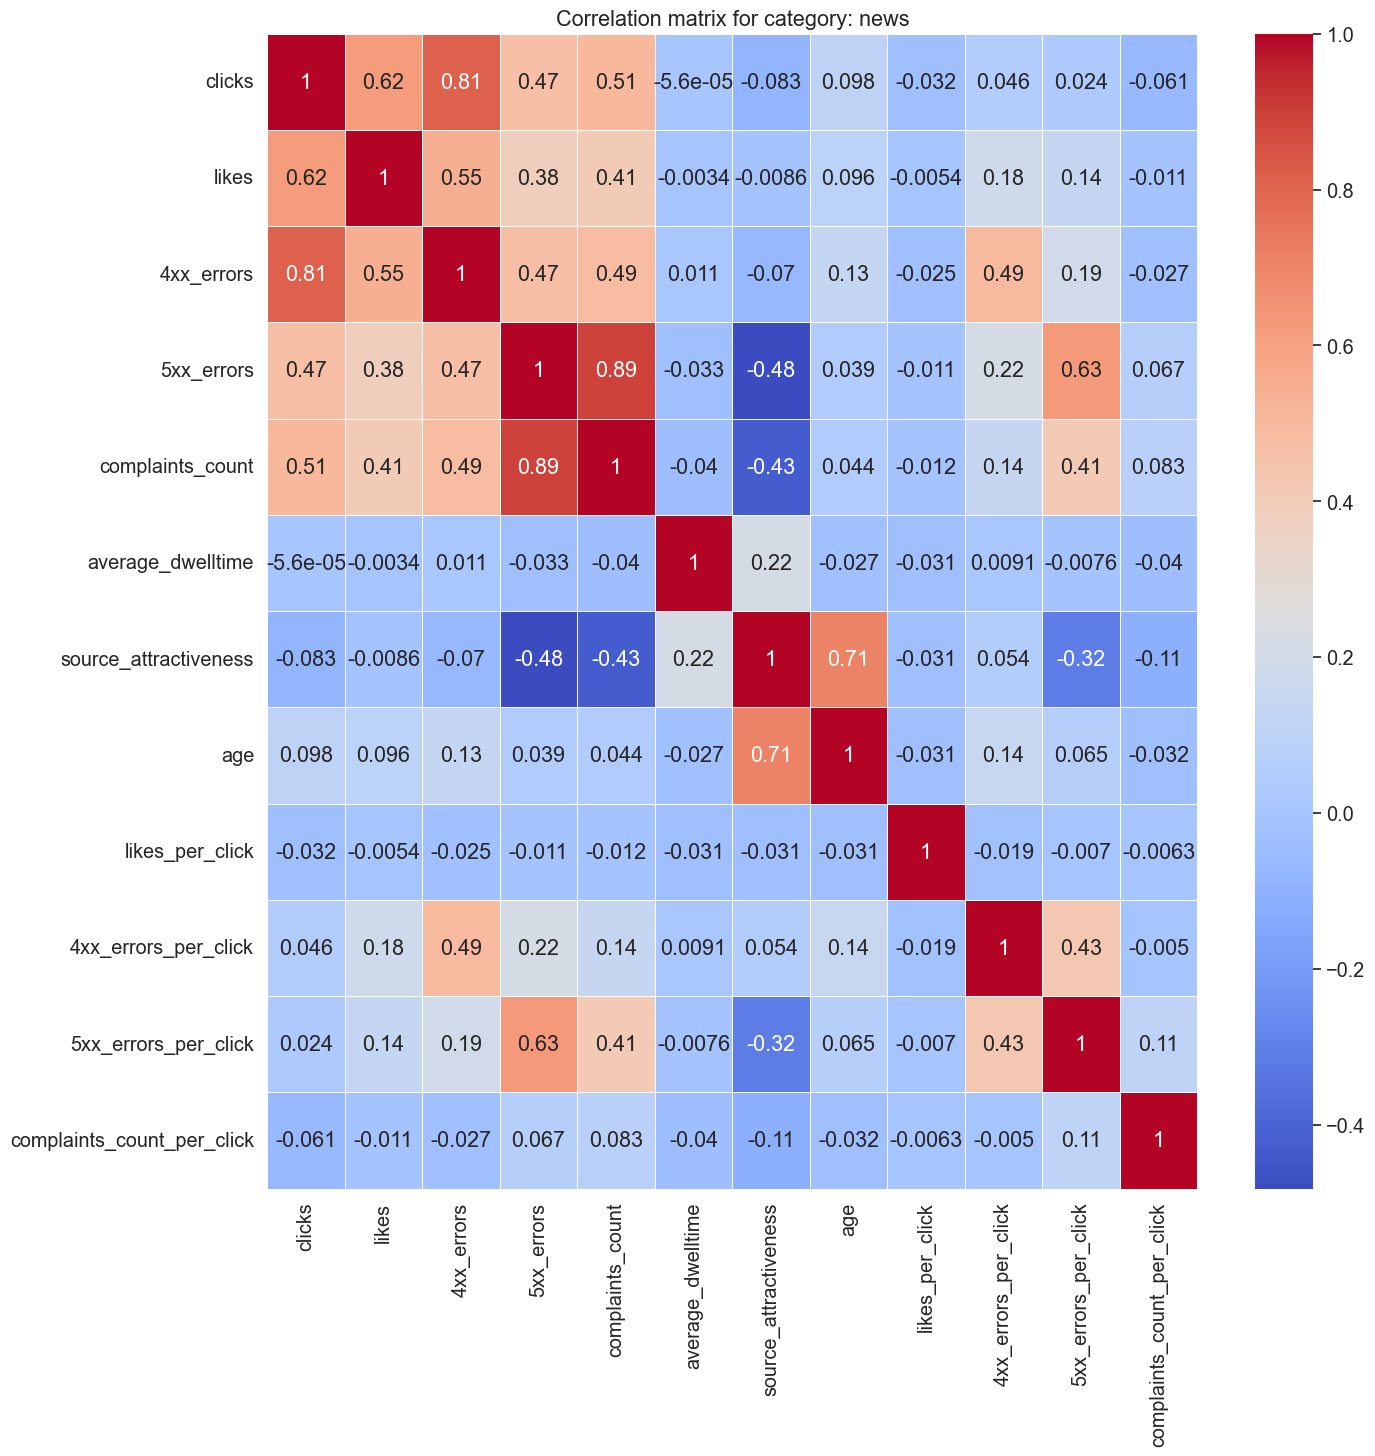

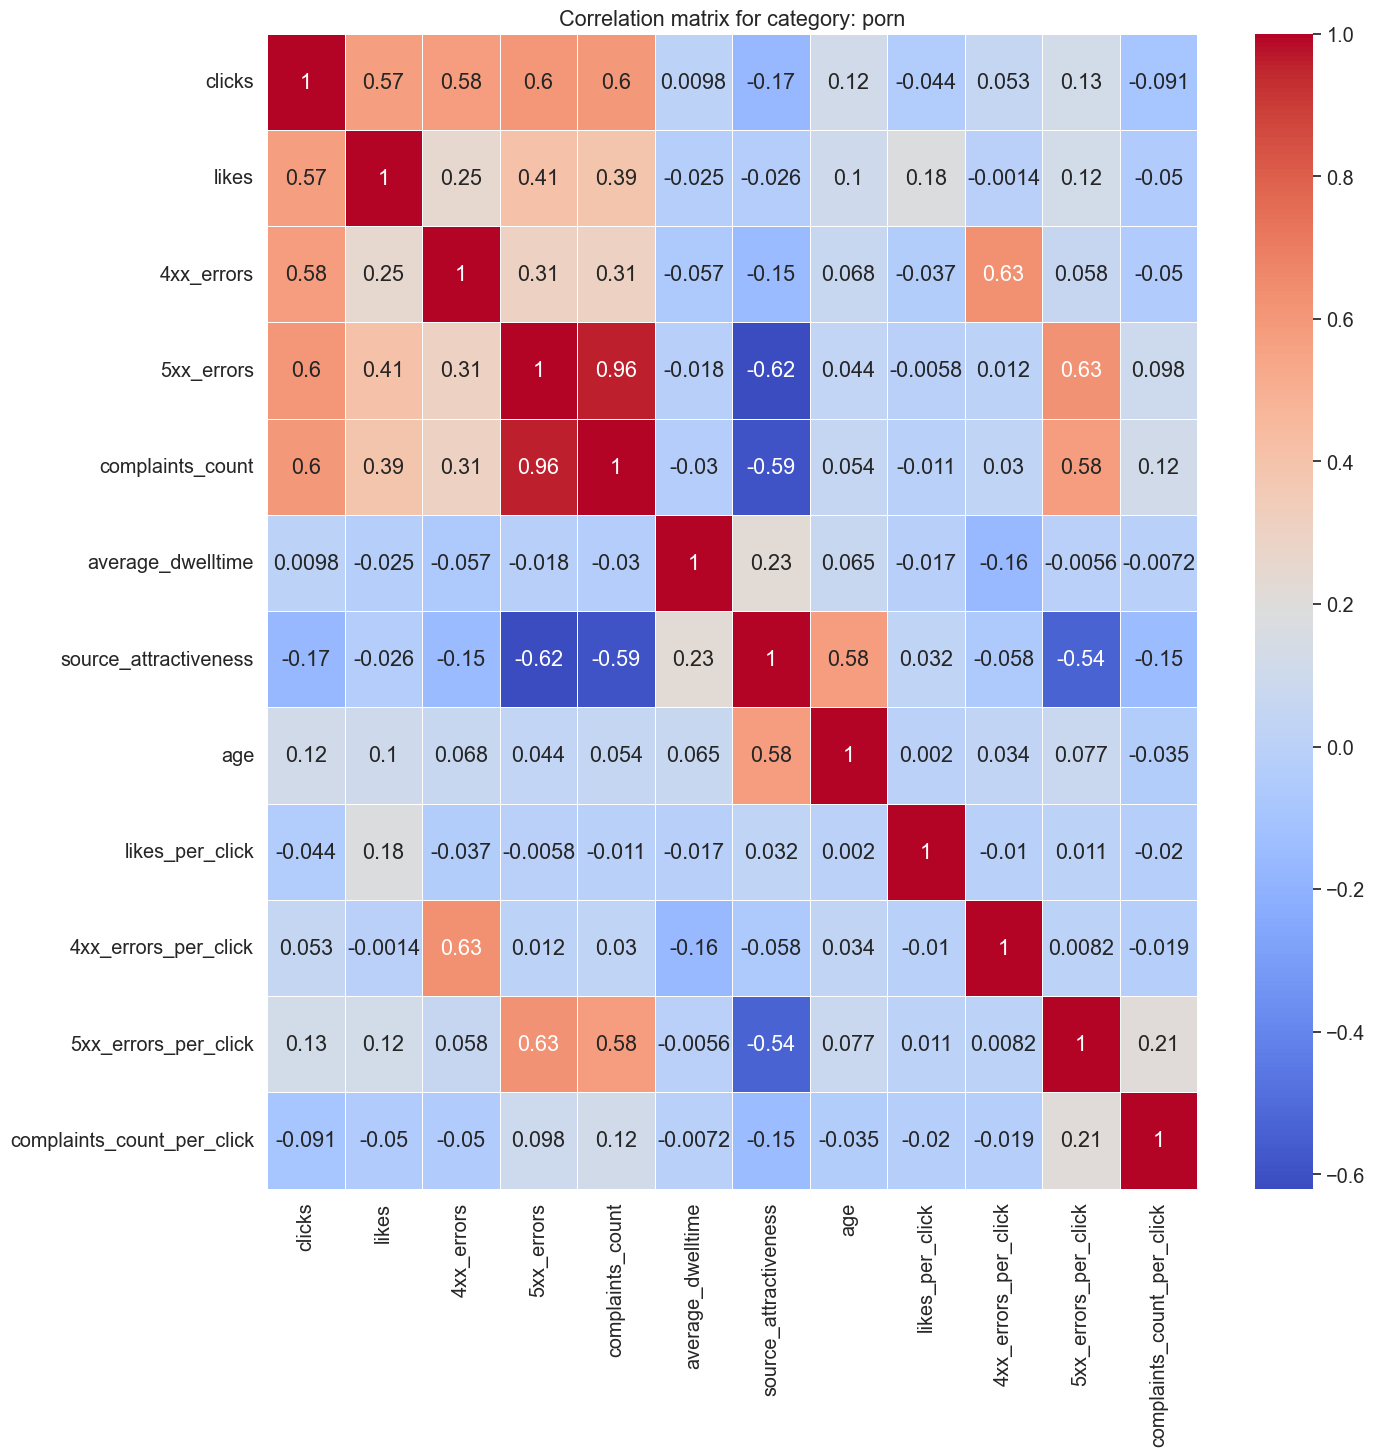

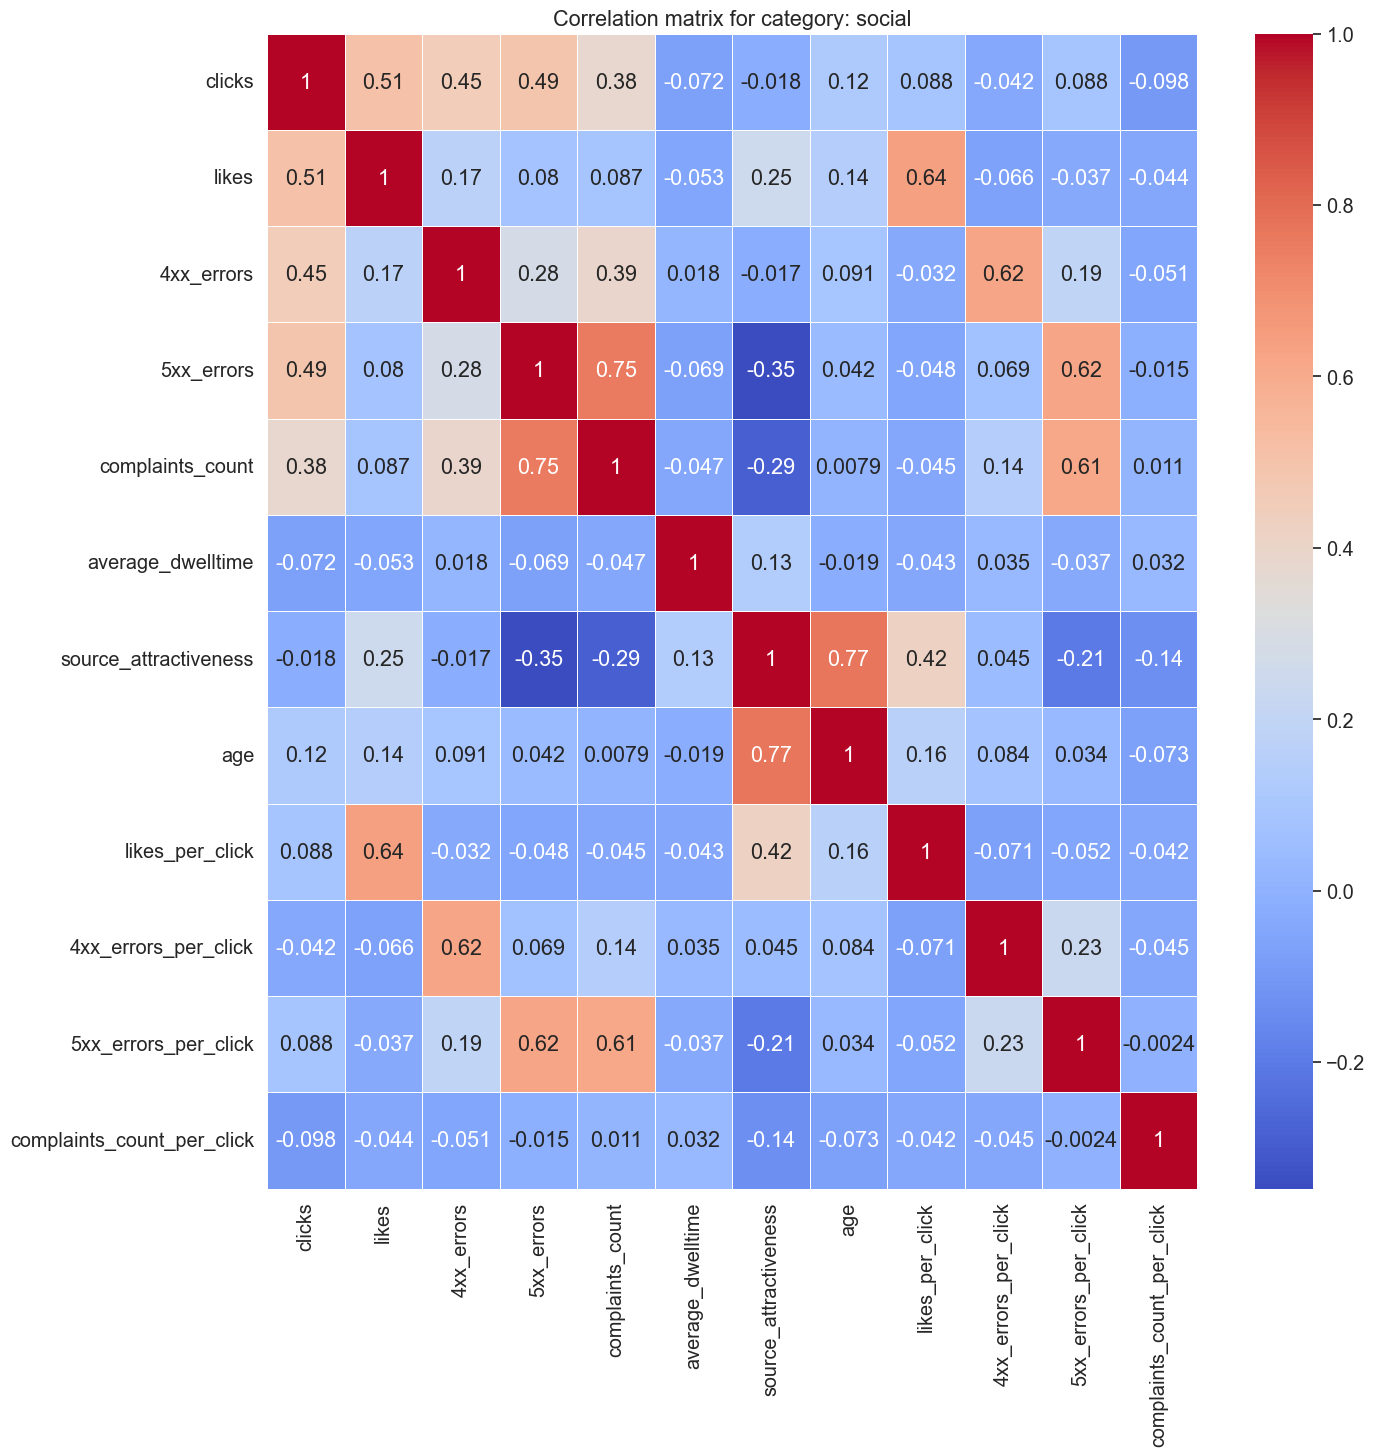

In [14]:
draw_corr_matrix('ecom', ecom_data, False)
draw_corr_matrix('information_source', information_source_data, False)
draw_corr_matrix('news', news_data, False)
draw_corr_matrix('porn', porn_data, False)
draw_corr_matrix('social', social_data, False)

Сделаем тоже самое с данными из test.csv

In [15]:
def clear_data(data):
    #data.rename(columns={'Unnamed: 0' : 'ID'}, inplace=True)
    data.set_index('ID',inplace=True)
    
    cleared_df = data.copy(deep=True)
    
    # Работа с датой
    cleared_df['complaints_count'] = pd.to_numeric(cleared_df['complaints_count'], errors='coerce')
    cleared_df['date_of_registration'] = pd.to_datetime(cleared_df['date_of_registration'])
    cleared_df['age'] = (pd.Timestamp('2024-10-15') - cleared_df['date_of_registration']) / pd.Timedelta(days=365)
    cleared_df = cleared_df.drop(['date_of_registration'], axis=1)

    # Заполняем пропуски медианным значением
    cleared_df.fillna(cleared_df.groupby(['category']).transform('median'), inplace=True)

    # Приводим к нужным типам
    cleared_df['clicks'] = cleared_df['clicks'].astype('int64')
    cleared_df['likes'] = cleared_df['likes'].astype('int64')
    cleared_df['buys'] = cleared_df['buys'].astype('int64')
    cleared_df['complaints_count'] = cleared_df['complaints_count'].astype('int64')
    
    # cleared_df = cleared_df[cleared_df['average_dwelltime'] >= 0]
    
    cleared_df['likes_per_click'] = cleared_df['likes'] / cleared_df['clicks']
    cleared_df['buys_per_click'] = cleared_df['buys'] / cleared_df['clicks']
    cleared_df['4xx_errors_per_click'] = cleared_df['4xx_errors'] / cleared_df['clicks']
    cleared_df['5xx_errors_per_click'] = cleared_df['5xx_errors'] / cleared_df['clicks']
    cleared_df['complaints_count_per_click'] = cleared_df['complaints_count'] / cleared_df['clicks']
    
    # Выделяем данные для каждой категории и удаляем колонку buys у колонок != ecom
    ecom_data = cleared_df[cleared_df['category'] == 'ecom'].drop(['category'], axis=1)
    information_source_data = cleared_df[cleared_df['category'] == 'information_source'].drop(['category', 'buys', 'buys_per_click'], axis=1)
    news_data = cleared_df[cleared_df['category'] == 'news'].drop(['category', 'buys', 'buys_per_click'], axis=1)
    porn_data = cleared_df[cleared_df['category'] == 'porn'].drop(['category', 'buys', 'buys_per_click'], axis=1)
    social_data = cleared_df[cleared_df['category'] == 'social'].drop(['category', 'buys', 'buys_per_click'], axis=1)
    
    return {"ecom_data": ecom_data,
            "information_source_data" : information_source_data,
            "news_data" : news_data,
            "porn_data" : porn_data,
            "social_data" : social_data}

### Обучение и тестирование моделей

In [16]:
def make_fit_model(data, target):
    X_train, X_test, Y_train, Y_test = train_test_split(
        data.drop(target, axis='columns'),
        data[target],
        test_size = 0.2,
        shuffle=True,
        random_state=1
    )
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, Y_train)
    return (model, X_test, Y_test)

In [17]:
ecom_model, ecom_X_test, ecom_Y_test = make_fit_model(ecom_data, 'source_attractiveness')
information_source_model, information_source_X_test, information_source_Y_test = make_fit_model(information_source_data, 'source_attractiveness')
news_model, news_X_test, news_Y_test = make_fit_model(news_data, 'source_attractiveness')
porn_model, porn_X_test, porn_Y_test = make_fit_model(porn_data, 'source_attractiveness')
social_model, social_X_test, social_Y_test = make_fit_model(social_data, 'source_attractiveness')

models = {
    'ecom_model' : ecom_model,
    'information_source_model' : information_source_model,
    'news_model' : news_model,
    'porn_model' : porn_model,
    'social_model' : social_model
}

In [18]:
ecom_predicts = ecom_model.predict(ecom_X_test)
information_source_predicts = information_source_model.predict(information_source_X_test)
news_predicts = news_model.predict(news_X_test)
porn_predicts = porn_model.predict(porn_X_test)
social_predicts = social_model.predict(social_X_test)

In [19]:
print("Test ecom predicts:")
metrics.mean_squared_error(ecom_Y_test, ecom_predicts), \
metrics.mean_absolute_error(ecom_Y_test, ecom_predicts), \
metrics.mean_absolute_percentage_error(ecom_Y_test, ecom_predicts) * 100

Test ecom predicts:


(0.00880965077284403, 0.07224805621279758, 182.25763084723624)

In [20]:
print("Test information_source predicts:")
metrics.mean_squared_error(information_source_Y_test, information_source_predicts), \
metrics.mean_absolute_error(information_source_Y_test, information_source_predicts), \
metrics.mean_absolute_percentage_error(information_source_Y_test, information_source_predicts) * 100

Test information_source predicts:


(0.004518107618670586, 0.050335346150721424, 102.72921417590968)

In [21]:
ecom_predicts = pd.DataFrame({'ID': ecom_Y_test.index, 'source_attractiveness': ecom_predicts})
information_source_predicts = pd.DataFrame({'ID': information_source_Y_test.index, 'source_attractiveness': information_source_predicts})
news_predicts = pd.DataFrame({'ID': news_Y_test.index, 'source_attractiveness': news_predicts})
porn_predicts = pd.DataFrame({'ID': porn_Y_test.index, 'source_attractiveness': porn_predicts})
social_predicts = pd.DataFrame({'ID': social_Y_test.index, 'source_attractiveness': social_predicts})

ecom_predicts.set_index('ID',inplace=True)
information_source_predicts.set_index('ID',inplace=True)
news_predicts.set_index('ID',inplace=True)
porn_predicts.set_index('ID',inplace=True)
social_predicts.set_index('ID',inplace=True)


predicts = pd.concat([ecom_predicts,
                       information_source_predicts,
                       news_predicts,
                       porn_predicts,
                       social_predicts])

Y_test = pd.concat([ecom_Y_test,
                    information_source_Y_test,
                    news_Y_test,
                    porn_Y_test,
                    social_Y_test])

In [22]:
print("Test predicts:")
metrics.mean_squared_error(Y_test, predicts), \
metrics.mean_absolute_error(Y_test, predicts), \
metrics.mean_absolute_percentage_error(Y_test, predicts) * 100

Test predicts:


(0.006521605849885007, 0.05657417532281203, 133.47663757161024)

Делаю предикты для test.csv

In [23]:
def make_predicts(data, models):
    cleared_data = clear_data(data)
    
    ecom_data = cleared_data['ecom_data']
    information_source_data = cleared_data['information_source_data']
    news_data = cleared_data['news_data']
    porn_data = cleared_data['porn_data']
    social_data = cleared_data['social_data']
     
    ecom_predicts = models['ecom_model'].predict(ecom_data)
    information_source_predicts = models['information_source_model'].predict(information_source_data)
    news_predicts = models['news_model'].predict(news_data)
    porn_predicts = models['porn_model'].predict(porn_data)
    social_predicts = models['social_model'].predict(social_data)
    
    ecom_predicts = pd.DataFrame({'ID': ecom_data.index, 'source_attractiveness': ecom_predicts})
    information_source_predicts = pd.DataFrame({'ID': information_source_data.index, 'source_attractiveness': information_source_predicts})
    news_predicts = pd.DataFrame({'ID': news_data.index, 'source_attractiveness': news_predicts})
    porn_predicts = pd.DataFrame({'ID': porn_data.index, 'source_attractiveness': porn_predicts})
    social_predicts = pd.DataFrame({'ID': social_data.index, 'source_attractiveness': social_predicts})
    
    ecom_predicts.set_index('ID',inplace=True)
    information_source_predicts.set_index('ID',inplace=True)
    news_predicts.set_index('ID',inplace=True)
    porn_predicts.set_index('ID',inplace=True)
    social_predicts.set_index('ID',inplace=True)
    
    return pd.concat([ecom_predicts,
                      information_source_predicts,
                      news_predicts,
                      porn_predicts,
                      social_predicts]).sort_index()
    

### Сабмит

In [24]:
test_df = pd.read_csv("test.csv")
submit = make_predicts(test_df, models)
submit.to_csv('submission.csv')